In [127]:
from matplotlib import pyplot as plt
import platform, os, sys
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm

if 'Windows' in platform.system():
    print "Working in Windows..."
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
elif 'Linux' in platform.system():
    print "Working in Linux..."
    sys.path.append(r'/mnt/s/_Data/160603 - EonHe M016v5/modules')
    from BEM import interpolate_slow
    %config InlineBackend.figure_format='retina'

from Common import common, kfit
from TrapAnalysis import trap_analysis, resonator_analysis, import_data
from HeliumSurface.static_surface import *

%matplotlib inline
#%config InlineBackend.figure_format='retina'

common.configure_axes(13)

Working in Linux...


In [135]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [9]:
reload(trap_analysis)
t = trap_analysis.TrapSolver(use_FEM_data=True)

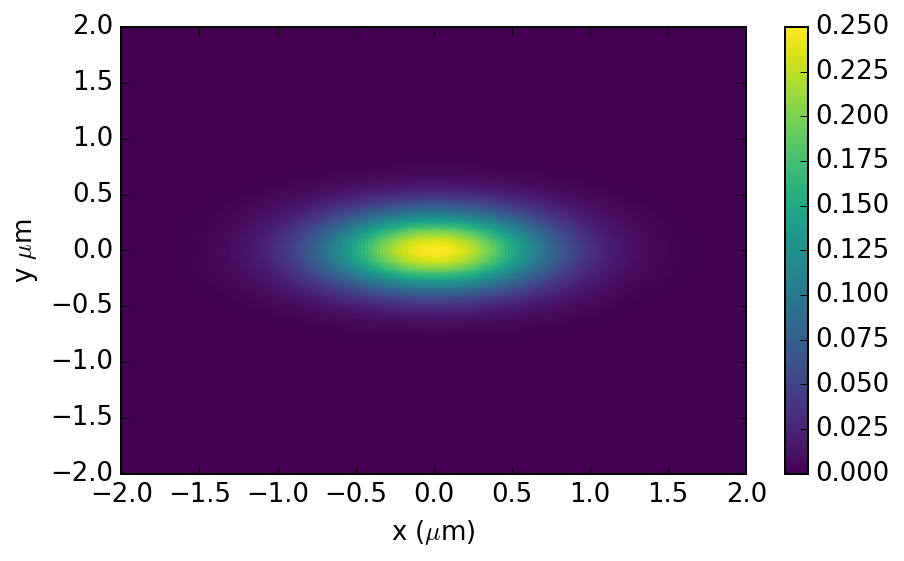

In [131]:
# Create a fake potential, V_DC and U_RF
x = np.linspace(-2.0E-6, 2.0E-6, 201)
y = np.linspace(-2.0E-6, 2.0E-6, 501)
X, Y = np.meshgrid(x, y)

sigma_x = 0.5E-6
sigma_y = 0.25E-6

V_DC = 0.25 * np.exp(-X**2/(2*sigma_x**2)) * np.exp(-Y**2/(2*sigma_y**2))

plt.figure(figsize=(7.,4.))
common.configure_axes(13)
plt.pcolormesh(X*1E6, Y*1E6, V_DC, cmap=plt.cm.viridis)
plt.colorbar()
plt.xlabel("x ($\mu$m)")
plt.ylabel("y $\mu$m")

The idea here is that you would load the potentials $U_{RF}$ and $V_{DC}$ from Finite Element software. Then the software calculates the derivatives for you, in the case for $E_x$ and $E_y$:
* $E_x = \frac{\partial U_\mathrm{RF}}{\partial x}$
* $E_y = \frac{\partial U_\mathrm{RF}}{\partial y}$

and in the case of the curvatures needed for the $K$ matrix:

* `curv_xx` $= \frac{\partial^2 V_\mathrm{DC}}{\partial x^2}$
* `curv_yy` $= \frac{\partial^2 V_\mathrm{DC}}{\partial y^2}$
* `curv_xy` $= \frac{\partial^2 V_\mathrm{DC}}{\partial x \partial y}$

# Define the derivative methods

<img src="https://en.wikipedia.org/api/rest_v1/media/math/render/svg/1d5ea4ce830449b5b62644bc6adf870f3e855c38"></img>
<img src="https://en.wikipedia.org/api/rest_v1/media/math/render/svg/7079a307343daf14febde8cef5e398c57df222cc"></img>
<img src="https://en.wikipedia.org/api/rest_v1/media/math/render/svg/56bc709daa40e0024dcc50af6ca07beedab07769"></img>

In [118]:
def curv_xx(x, y, f):
    """
    x = np.array([[x0, x1, x2, ...], 
                  [x0, x1, x2, ...], 
                  [x0, x1, x2, ...],
                  ...)
    y = np.array([[y0, y0, y0, ...], 
                  [y1, y1, y1, ...], 
                  [y2, y2, y2, ...], 
                  ...)
    """
    nx = np.shape(x)[1]
    ny = np.shape(x)[0]
    new_x = x[1:ny-1,1:nx-1]
    new_y = y[1:ny-1,1:nx-1]
    h = x[0,1] - x[0,0]
    f_xx = (f[1:ny-1, 2:nx] -2*f[1:ny-1, 1:nx-1]+ f[1:ny-1, 0:nx-2])/(h**2)
    return new_x, new_y, f_xx

def curv_yy(x, y, f):
    """
    x = np.array([[x0, x1, x2, ...], 
                  [x0, x1, x2, ...], 
                  [x0, x1, x2, ...],
                  ...)
    y = np.array([[y0, y0, y0, ...], 
                  [y1, y1, y1, ...], 
                  [y2, y2, y2, ...], 
                  ...)
    """
    nx = np.shape(x)[1]
    ny = np.shape(x)[0]
    new_x = x[1:ny-1,1:nx-1]
    new_y = y[1:ny-1,1:nx-1]
    h = y[1,0] - y[0,0]
    f_xx = (f[2:ny, 1:nx-1] -2*f[1:ny-1, 1:nx-1]+ f[0:ny-2, 1:nx-1])/(h**2)
    return new_x, new_y, f_xx

def curv_xy(x, y, f):
    """
    x = np.array([[x0, x1, x2, ...], 
                  [x0, x1, x2, ...], 
                  [x0, x1, x2, ...],
                  ...)
    y = np.array([[y0, y0, y0, ...], 
                  [y1, y1, y1, ...], 
                  [y2, y2, y2, ...], 
                  ...)
    """
    nx = np.shape(x)[1]
    ny = np.shape(x)[0]
    new_x = x[1:ny-1,1:nx-1]
    new_y = y[1:ny-1,1:nx-1]
    dy = y[1,0] - y[0,0]
    dx = x[0,1] - x[0,0]

    f_xy  = (f[2:ny, 2:nx] - f[2:ny, 0:nx-2] - f[0:ny-2, 2:nx] + f[0:ny-2, 0:nx-2])/(4*dx*dy)
    
    return new_x, new_y, f_xy

(499, 199) (499, 199) (499, 199)
(499, 199) (499, 199) (499, 199)
(499, 199) (499, 199) (499, 199)


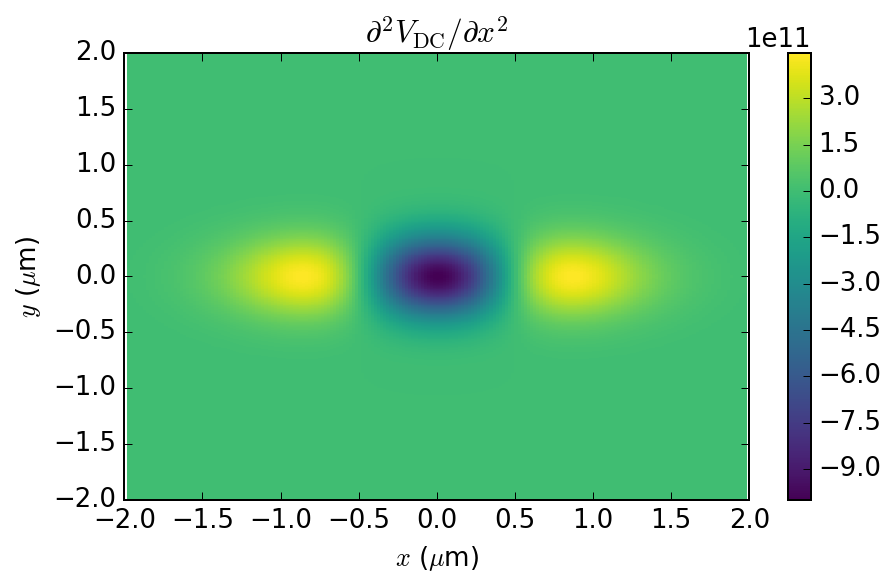

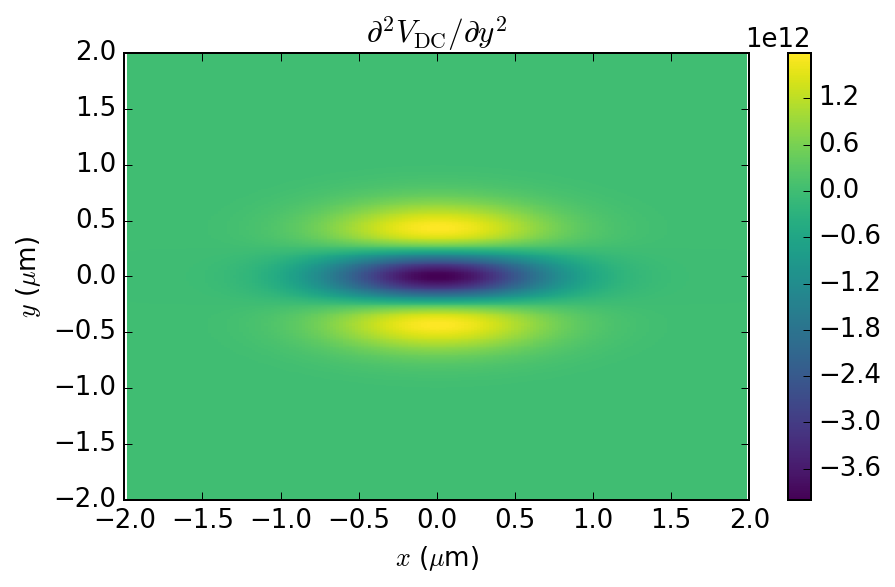

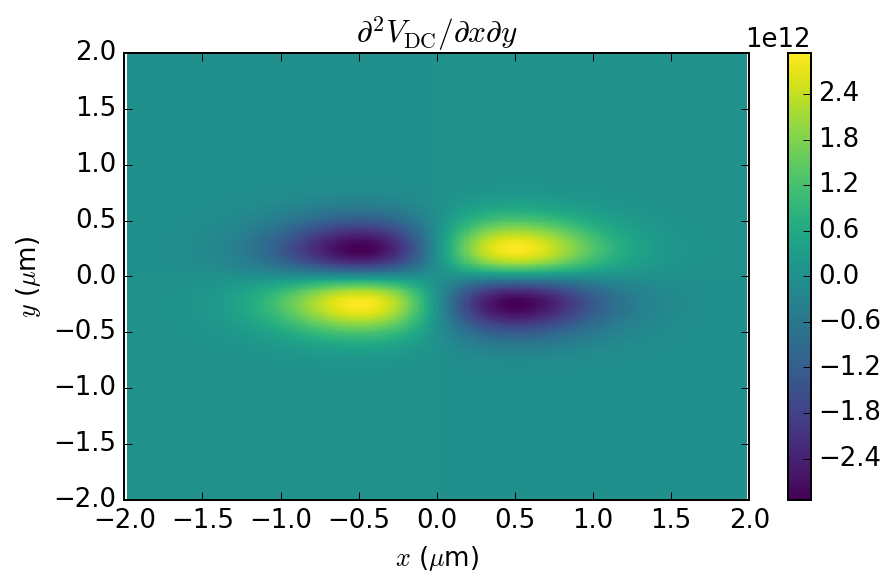

In [119]:
x_plot, y_plot, f_xx_plot = curv_xx(X, Y, V_DC)

print np.shape(x_plot), np.shape(y_plot), np.shape(f_xx_plot)

fig = plt.figure(figsize=(7.,4.))
ax = plt.gca()
ax.set_axis_bgcolor('none')
plt.pcolormesh(x_plot*1E6, y_plot*1E6, f_xx_plot, cmap=plt.cm.viridis)
plt.colorbar()
plt.xlabel('$x$ ($\mu$m)')
plt.ylabel('$y$ ($\mu$m)')
plt.title('$\partial^2 V_\mathrm{DC}/\partial x^2$')

x_plot, y_plot, f_yy_plot = curv_yy(X, Y, V_DC)

print np.shape(x_plot), np.shape(y_plot), np.shape(f_yy_plot)

fig = plt.figure(figsize=(7.,4.))
ax = plt.gca()
ax.set_axis_bgcolor('none')
plt.pcolormesh(x_plot*1E6, y_plot*1E6, f_yy_plot, cmap=plt.cm.viridis)
plt.colorbar()
plt.xlabel('$x$ ($\mu$m)')
plt.ylabel('$y$ ($\mu$m)')
plt.title('$\partial^2 V_\mathrm{DC}/\partial y^2$')

x_plot, y_plot, f_xy_plot = curv_xy(X, Y, V_DC)

print np.shape(x_plot), np.shape(y_plot), np.shape(f_xy_plot)

fig = plt.figure(figsize=(7.,4.))
ax = plt.gca()
ax.set_axis_bgcolor('none')
plt.pcolormesh(x_plot*1E6, y_plot*1E6, f_xy_plot, cmap=plt.cm.viridis)
plt.colorbar()
plt.xlabel('$x$ ($\mu$m)')
plt.ylabel('$y$ ($\mu$m)')
plt.title('$\partial^2 V_\mathrm{DC}/\partial x \partial y$')

In [120]:
print "Mesh spacing is dx, dy = %.2f x %.2f nm"%((X[0,1]-X[0,0])*1E9, (Y[1,0]-Y[0,0])*1E9)

Mesh spacing is dx, dy = 20.00 x 8.00 nm


<img src="https://en.wikipedia.org/api/rest_v1/media/math/render/svg/335a361d18b1a1dd01f578ad252a70d93748151d"></img>
<img src="https://en.wikipedia.org/api/rest_v1/media/math/render/svg/e77eff5d9ef8462ca0e4031a8aa96ac857b60a15"></img>

In [128]:
def Ex(x, y, f):
    """
    x = np.array([[x0, x1, x2, ...], 
                  [x0, x1, x2, ...], 
                  [x0, x1, x2, ...],
                  ...)
    y = np.array([[y0, y0, y0, ...], 
                  [y1, y1, y1, ...], 
                  [y2, y2, y2, ...], 
                  ...)
    """
    nx = np.shape(x)[1]
    ny = np.shape(x)[0]
    new_x = x[1:ny-1,1:nx-1]
    new_y = y[1:ny-1,1:nx-1]
    dy = y[1,0] - y[0,0]
    dx = x[0,1] - x[0,0]

    f_x  = (f[1:ny-1, 2:nx] - f[1:ny-1, 0:nx-2])/(2*dx)
    
    return new_x, new_y, f_x

def Ey(x, y, f):
    """
    x = np.array([[x0, x1, x2, ...], 
                  [x0, x1, x2, ...], 
                  [x0, x1, x2, ...],
                  ...)
    y = np.array([[y0, y0, y0, ...], 
                  [y1, y1, y1, ...], 
                  [y2, y2, y2, ...], 
                  ...)
    """
    nx = np.shape(x)[1]
    ny = np.shape(x)[0]
    new_x = x[1:ny-1,1:nx-1]
    new_y = y[1:ny-1,1:nx-1]
    dy = y[1,0] - y[0,0]
    dx = x[0,1] - x[0,0]

    f_y  = (f[2:ny, 1:nx-1] - f[0:ny-2, 1:nx-1])/(2*dy)
    
    return new_x, new_y, f_y

(499, 199) (499, 199) (499, 199)
(499, 199) (499, 199) (499, 199)


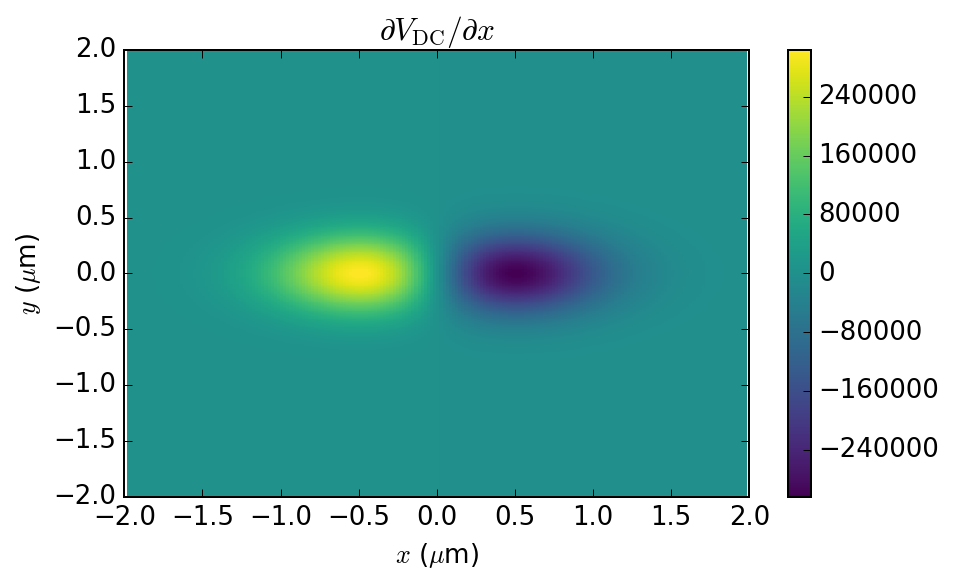

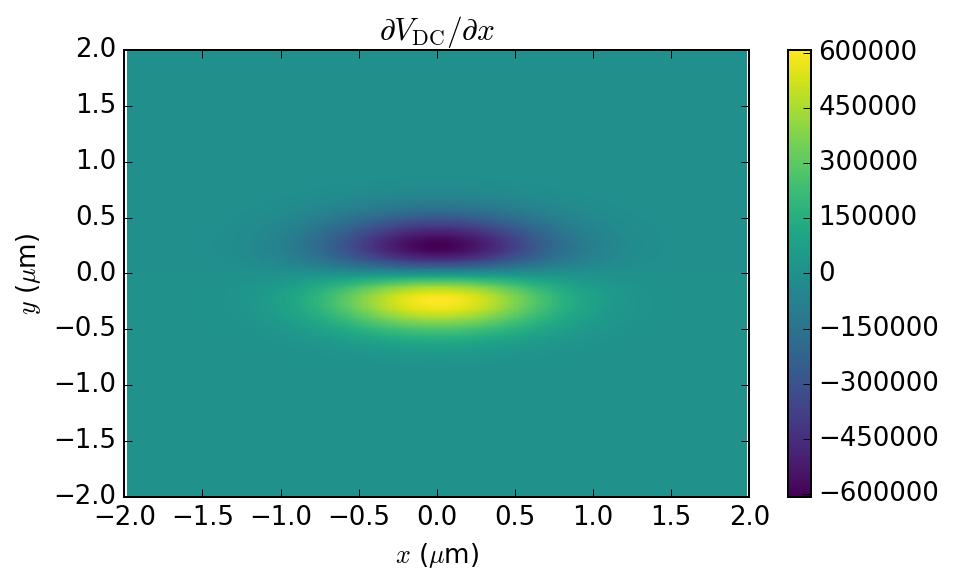

In [130]:
x_plot, y_plot, f_x_plot = Ex(X, Y, V_DC)
print np.shape(x_plot), np.shape(y_plot), np.shape(f_x_plot)

fig = plt.figure(figsize=(7.,4.))
ax = plt.gca()
ax.set_axis_bgcolor('none')
plt.pcolormesh(x_plot*1E6, y_plot*1E6, f_x_plot, cmap=plt.cm.viridis)
plt.colorbar()
plt.xlabel('$x$ ($\mu$m)')
plt.ylabel('$y$ ($\mu$m)')
plt.title('$\partial V_\mathrm{DC}/\partial x$')

x_plot, y_plot, f_y_plot = Ey(X, Y, V_DC)
print np.shape(x_plot), np.shape(y_plot), np.shape(f_y_plot)

fig = plt.figure(figsize=(7.,4.))
ax = plt.gca()
ax.set_axis_bgcolor('none')
plt.pcolormesh(x_plot*1E6, y_plot*1E6, f_y_plot, cmap=plt.cm.viridis)
plt.colorbar()
plt.xlabel('$x$ ($\mu$m)')
plt.ylabel('$y$ ($\mu$m)')
plt.title('$\partial V_\mathrm{DC}/\partial y$')

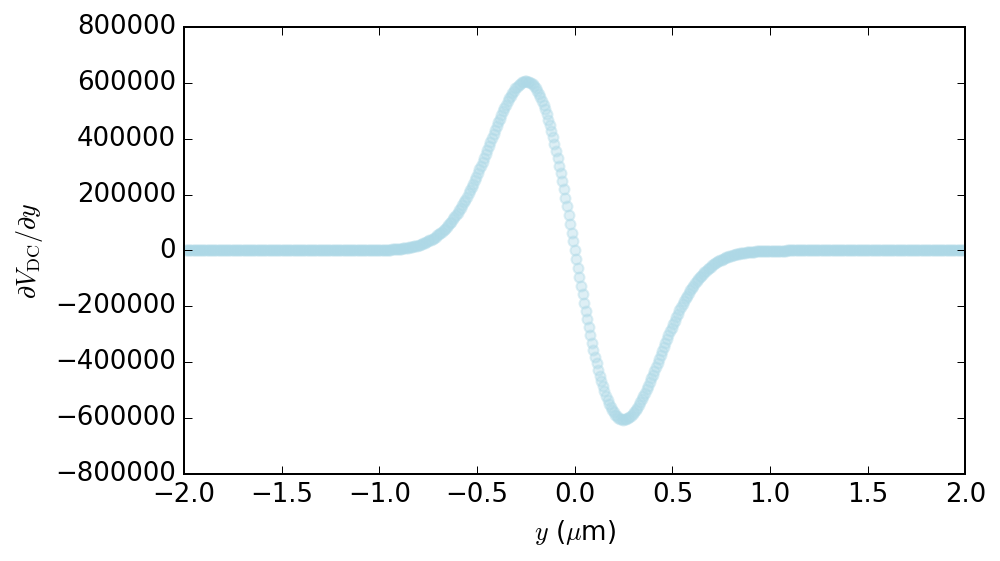

In [134]:
plt.figure(figsize=(7.,4.))
ax = plt.gca()
ax.set_axis_bgcolor('none')
plt.plot(y_plot[:,0]*1E6, f_y_plot[:,np.shape(f_y_plot)[1]/2], linestyle='None', **common.plot_opt('lightblue', msize=5))
plt.xlabel('$y$ ($\mu$m)')
plt.ylabel('$\partial V_\mathrm{DC}/\partial y$')